# Post-Review-Synthetic-Data-V4.1_addedFPs

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

# Input data files are available in the "./input_data/" directory.
import os
print(os.listdir("./input_data/final"))
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.tools.plotting import table

Using TensorFlow backend.


['clean_test_allFP.csv', 'clean_test_greedyFP.csv', 'clean_test_leakFP.csv', 'clean_test_suicidalFP.csv', 'clean_train.csv', 'LsMa', 'no_duplicates', 'old_no_duplicates']


### Defining functions

In [2]:
def label(df):    
    # label data
    df['LABEL'] = 0
    df.loc[df['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
    df.loc[df['CATEGORY'] != '1 0 0 0', 'LABEL'] = 1
    
def preprocess(df):
    n_most_common_words = 1000 #8000
    max_len = 130

    # Class Tokenizer - This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary)
    # tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer = Tokenizer(num_words=n_most_common_words, lower=False)

    # fit_on_texts - Updates internal vocabulary based on a list of texts. In the case where texts contains lists, we assume each entry of the lists to be a token.
    # tokenizer.fit_on_texts(increased_vul['OPCODE'].values)
    tokenizer.fit_on_texts(df['OPCODE'].values)

    # # Transforms each text in texts in a sequence of integers.
    sequences = tokenizer.texts_to_sequences(df['OPCODE'].values)
    # sequences = tokenizer.texts_to_sequences(tt)

    #Find number of unique words/tokens
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    #pad sequences with zeros in front to make them all maxlen
    X = pad_sequences(sequences, maxlen=max_len)
    return X

def dftoXY(df):
    # Save test X and y
    X_test = preprocess(df)
    # label data
    label(df)
#     df['LABEL'] = 0
#     df.loc[df['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
#     df.loc[df['CATEGORY'] != '1 0 0 0', 'LABEL'] = 1
    print(pd.value_counts(df['LABEL']))
    y_test = to_categorical(df['LABEL'], num_classes=2)
    return X_test, y_test    

def XandY(posdf, negdf=None):
    dfset = pd.concat([posdf, negdf])
    dfset = dfset.sample(frac=1, random_state=39, replace=False)

    dfset['LABEL'] = 0

    #One-hot encode the lab
    dfset.loc[dfset['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
    dfset.loc[dfset['CATEGORY'] != '1 0 0 0', 'LABEL'] = 1
    # df_train.head()

    X, y = dftoXY(dfset)

    print('Shape of X: {}'.format(X.shape))

    # for sm.fit_sample
    y_labels = np.expand_dims(np.array(np.argmax(y, axis=1)), axis=1)
    print('Shape of y: {}'.format(y_labels.shape))

    return X, y_labels

### Loading the dataset

In [3]:
# Loading and reading csv input data 
# dataset = 'results_merged_12-10-2018_noTP.csv'
# dataset = 'results_merged_12-10-2018_dataset1_greedy.csv'
# dataset = 'results_fixed_first100k.csv'
dataset = 'clean_train.csv'
data = pd.read_csv('./input_data/final/'+dataset, usecols=['ADDRESS', 'OPCODE', 'CATEGORY'])
data.head()

,ADDRESS,OPCODE,CATEGORY
0,0x219f4ee903f78e78773e5d1e3520cfd507485bc6,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
1,0x560ed796aa8d23411b94b9d047ecdda39d4fcdeb,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
2,0xe726f97ff3c63dd71c1520c102adc39d1a2693ea,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
3,0x8ebac490495958b3804bb079e259340f0f53b69c,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0
4,0x190700d69031db6b072a30577f9b3dbc53a320a1,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...,1 0 0 0


### Checking the target classes

In [4]:
pd.value_counts(data['CATEGORY'])

1 0 0 0    884273
0 0 0 1      5801
0 0 1 0      1461
0 1 0 0      1207
0 1 1 0       171
Name: CATEGORY, dtype: int64

### Plot unbalanced

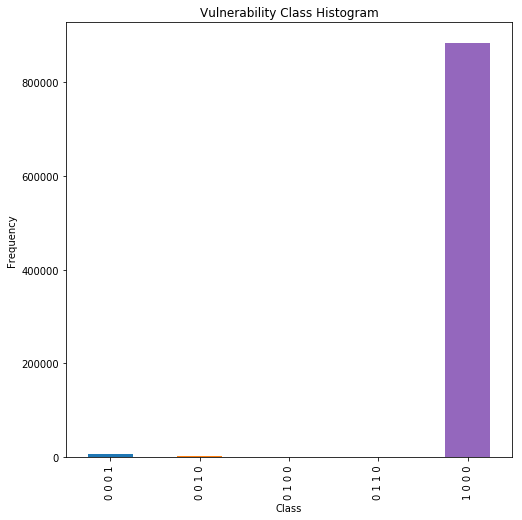

In [5]:
fig = plt.figure()
count_classes = pd.value_counts(data['CATEGORY'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Vulnerability Class Histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
fig.set_size_inches(8, 8)
plt.show()
# fig.savefig('./figures/clean_train_unbalanced_distr.png', dpi=300) #, bbox_inches='tight'

### Dividing data into vulnerable and non-vulnerable

In [7]:
# shuffled = data.reindex(np.random.permutation(data.index))
shuffled = data

# shuffled = data
n = shuffled[shuffled['CATEGORY'] == '1 0 0 0'] # no vulnerabilities
s = shuffled[shuffled['CATEGORY'] == '0 1 0 0'] # suicidal
p = shuffled[shuffled['CATEGORY'] == '0 0 1 0'] # prodigal
g = shuffled[shuffled['CATEGORY'] == '0 0 0 1'] # greedy
sp = shuffled[shuffled['CATEGORY'] == '0 1 1 0'] # suicidal and prodigal

### Plot two class unbalanced

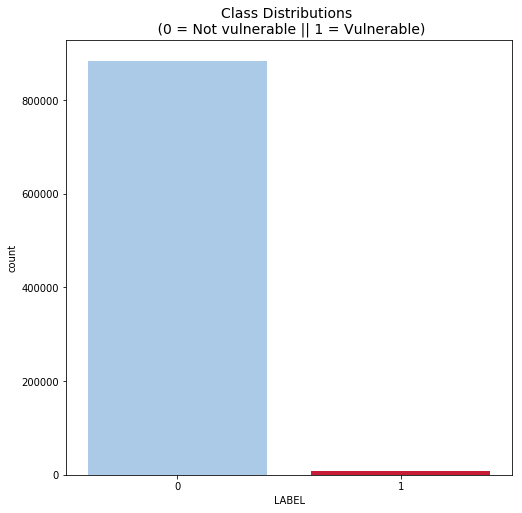

In [154]:
concated = pd.concat([n,s,p,g,sp], ignore_index=True)

#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

#One-hot encode the lab
concated.loc[concated['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
concated.loc[concated['CATEGORY'] != '1 0 0 0', 'LABEL'] = 1

import seaborn as sns
fig = plt.figure()
# colors = ["#0101DF", "#DF0101"]
colors = ["#A1CAF1", "#E30022"]

sns.countplot('LABEL', data=concated, palette=colors)
plt.title('Class Distributions \n (0 = Not vulnerable || 1 = Vulnerable)', fontsize=14)
fig.set_size_inches(8, 8)
# fig.savefig('./figures/clean_train_unbalanced2class.png', dpi=300) #, bbox_inches='tight'

### Dividing data into train, validation, and test

In [9]:
# ========== set of vul contracts ========== 
# shuffle positives dataset
positives = pd.concat([s,p,g,sp])
positives_shuf = positives.sample(frac=1, random_state=39, replace=False)
print(len(positives_shuf))

# split positives dataset into train, val, and test
proportion_train = 0.64 #0.7 
proportion_val = 0.16 #0.1 
proportion_test = 0.2 #0.20

num_pos_train = round(len(positives_shuf) * proportion_train)
num_pos_val = round(len(positives_shuf) * proportion_val)

pos_train = positives_shuf.iloc[0:num_pos_train] 
pos_val = positives_shuf.iloc[num_pos_train:(num_pos_train+num_pos_val)]
pos_test = positives_shuf.iloc[(num_pos_train+num_pos_val):]

# print(len(pos_train))
# print(len(pos_val))
# print(len(pos_test))

8640


In [133]:
# ========== set of non-vul contracts ========== 
# # shuffle set n
n_shuf = n.sample(frac=1, random_state=39, replace=False)

n_shuf['FP'] = 0
# set number of samples in each set
num_neg_train = 9000 #30000 #11000
num_neg_val = round(((num_neg_train)/proportion_train)*proportion_val)
num_neg_test = round(((num_neg_train)/proportion_train)*proportion_test)

neg_train = n_shuf.iloc[0:num_neg_train]
neg_val = n_shuf.iloc[num_neg_train:(num_neg_train+num_neg_val)]
neg_test = n_shuf.iloc[(num_neg_train+num_neg_val):(num_neg_train+num_neg_val+num_neg_test)]

# neg_notused = n_shuf.iloc[(num_neg_train+num_neg_val+num_neg_test):]
# print("Number of negative samples not used: ", len(neg_notused))

# print(len(neg_train))
# print(len(neg_val))
# print(len(neg_test))

In [134]:
# ========== adding FPs into non-vul training set ========== 
# FPs = "clean_test_allFP_noDups.csv"
# allFPs = pd.read_csv('./input_data/final/no_duplicates/'+ FPs, usecols=['ADDRESS', 'OPCODE', 'CATEGORY'])
# all_testset = 'clean_test_allFP_noDups.csv'
leakFP = 'clean_test_leakFP_noDups.csv'
suicidalFP = 'clean_test_suicidalFP_noDups.csv'
greedyFP = 'clean_test_greedyFP_noDups.csv'

leakFPs = pd.read_csv('./input_data/final/no_duplicates/'+leakFP, usecols=['ADDRESS', 'OPCODE', 'CATEGORY'])
print("Total Number of Leak FPs: ", len(leakFPs))
suicidalFPs = pd.read_csv('./input_data/final/no_duplicates/'+suicidalFP, usecols=['ADDRESS', 'OPCODE', 'CATEGORY'])
print("Total Number of Suicidal FPs: ", len(suicidalFPs))
greedyFPs = pd.read_csv('./input_data/final/no_duplicates/'+greedyFP, usecols=['ADDRESS', 'OPCODE', 'CATEGORY'])
print("Total Number of Greedy FPs: ", len(greedyFPs))

# Split FPs into training and test set
FPtrain_frac = 0.8
def FPsplit(df, train_frac):
    msk = np.random.rand(len(df)) <= train_frac
    train_df = df[msk]
    test_df = df[~msk]
    return train_df, test_df

train_leakFPs, test_leakFPs = FPsplit(leakFPs, FPtrain_frac)
print("Number of Leak FPs for Training: ", len(train_leakFPs))
print("Number of Leak FPs for Test: ", len(test_leakFPs))

train_suicidalFPs, test_suicidalFPs = FPsplit(suicidalFPs, FPtrain_frac)
print("Number of Suicidal FPs for Training: ", len(train_suicidalFPs))
print("Number of Suicidal FPs for Test: ", len(test_suicidalFPs))

train_lockFPs, test_lockFPs = FPsplit(greedyFPs, FPtrain_frac)
print("Number of Lock FPs for Training: ", len(train_lockFPs))
print("Number of Lock FPs for Test: ", len(test_lockFPs))

trainFPs = pd.concat([train_leakFPs, train_suicidalFPs, train_lockFPs])

# add column to classify FPs and non-FPs
trainFPs['FP'] = 1

numFPs = len(trainFPs)
# print("Number of Original Negatives: ", len(neg_train))
print("Number of FPs: ", numFPs) #allFPs

Total Number of Leak FPs:  177
Total Number of Suicidal FPs:  72
Total Number of Greedy FPs:  202
Number of Leak FPs for Training:  141
Number of Leak FPs for Test:  36
Number of Suicidal FPs for Training:  59
Number of Suicidal FPs for Test:  13
Number of Lock FPs for Training:  148
Number of Lock FPs for Test:  54
Number of FPs:  348


In [132]:
negval_addFP.head()

,ADDRESS,CATEGORY,FP,OPCODE
7356,0xd52351f24702f2544a455a64c4d00c956a323614,1 0 0 0,NaN,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...
59163,0x9ebe9f86af71452d881875be50df5bf8180ea06a,1 0 0 0,NaN,60 60 52 36 15 61 57 60 60 0a 60 35 04 63 81 1...
804669,0xa3aea63ace61db42e4b63328234688c857f0d36d,1 0 0 0,NaN,60 60 52 60 60 0a 60 35 04 63 81 14 60 57 5b 6...
613041,0x36a8759350cc9ef5216d2d2aa06ef95f93854611,1 0 0 0,NaN,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...
801456,0xb3d8c02a09156e7a431fa3ecca058f7952ae8aae,1 0 0 0,NaN,60 60 52 36 15 61 57 60 35 7c 90 04 63 16 80 6...


In [139]:
# set number of samples in each set
numtrainFPs = round(numFPs*proportion_train)
numvalFPs = round(numFPs*proportion_val)
numtestFPs = numFPs - numtrainFPs - numvalFPs

FP_train = trainFPs.iloc[0:numtrainFPs]
FP_val = trainFPs.iloc[numtrainFPs:(numtrainFPs+numvalFPs)]
FP_test = trainFPs.iloc[(numtrainFPs+numvalFPs):(numtrainFPs+numvalFPs+numtestFPs)]

# Concatenate dfs
negtrain_addFP = pd.concat([neg_train, FP_train])
negval_addFP = pd.concat([neg_val, FP_val])
negtest_addFP = pd.concat([neg_test, FP_test])
# Shuffle df
negtrain_addFP = negtrain_addFP.sample(frac=1, random_state=39, replace=False)
negval_addFP = negval_addFP.sample(frac=1, random_state=39, replace=False)
negtest_addFP = negtest_addFP.sample(frac=1, random_state=39, replace=False)
# Processing X and y
Xnegtrain_addFP = preprocess(negtrain_addFP)
ynegtrain_addFP = to_categorical(negtrain_addFP['FP'], num_classes=2)
Xnegval_addFP = preprocess(negval_addFP)
ynegval_addFP = to_categorical(negval_addFP['FP'], num_classes=2)
Xnegtest_addFP = preprocess(negtest_addFP)
ynegtest_addFP = to_categorical(negtest_addFP['FP'], num_classes=2)
# for sm.fit_sample
ynegtrain_addFP_labels = np.expand_dims(np.array(np.argmax(ynegtrain_addFP, axis=1)), axis=1)
print('Shape of X: {}'.format(Xnegtrain_addFP.shape))
print('Shape of y: {}'.format(ynegtrain_addFP_labels.shape))
ynegval_addFP_labels = np.expand_dims(np.array(np.argmax(ynegval_addFP, axis=1)), axis=1)
print('Shape of X: {}'.format(Xnegval_addFP.shape))
print('Shape of y: {}'.format(ynegval_addFP_labels.shape))
ynegtest_addFP_labels = np.expand_dims(np.array(np.argmax(ynegtest_addFP, axis=1)), axis=1)
print('Shape of X: {}'.format(Xnegtest_addFP.shape))
print('Shape of y: {}'.format(ynegtest_addFP_labels.shape))

# Prepare train set 
# Xneg_train, ynegtrain_labels = XandY(neg_train, allFPs, label='FP')
print("Number transactions X_negtrain dataset: ", Xnegtrain_addFP.shape)
print("Number transactions y_negtrain dataset: ", ynegtrain_addFP_labels.shape)
print("Before OverSampling, train counts of label '1': {}".format(sum(ynegtrain_addFP_labels==1)))
print("Before OverSampling, train counts of label '0': {}".format(sum(ynegtrain_addFP_labels==0)))
print("Before OverSampling, val counts of label '1': {}".format(sum(ynegval_addFP_labels==1)))
print("Before OverSampling, val counts of label '0': {}".format(sum(ynegval_addFP_labels==0)))
print("Before OverSampling, test counts of label '1': {}".format(sum(ynegtest_addFP_labels==1)))
print("Before OverSampling, test counts of label '0': {}".format(sum(ynegtest_addFP_labels==0)))

Found 150 unique tokens.
Found 150 unique tokens.
Found 150 unique tokens.
Shape of X: (9223, 130)
Shape of y: (9223, 1)
Shape of X: (2306, 130)
Shape of y: (2306, 1)
Shape of X: (2881, 130)
Shape of y: (2881, 1)
Number transactions X_negtrain dataset:  (9223, 130)
Number transactions y_negtrain dataset:  (9223, 1)
Before OverSampling, train counts of label '1': [223]
Before OverSampling, train counts of label '0': [9000]
Before OverSampling, val counts of label '1': [56]
Before OverSampling, val counts of label '0': [2250]
Before OverSampling, test counts of label '1': [69]
Before OverSampling, test counts of label '0': [2812]


In [140]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(ratio=0.35, random_state=39)

In [142]:
Xnegtrain_res, ynegtrain_res = smt.fit_sample(Xnegtrain_addFP, ynegtrain_addFP_labels.ravel())
Xnegval_res, ynegval_res = smt.fit_sample(Xnegval_addFP, ynegval_addFP_labels.ravel())
Xnegtest_res, ynegtest_res = smt.fit_sample(Xnegtest_addFP, ynegtest_addFP_labels.ravel())

print('After OverSampling, the shape of train_X: {}'.format(Xnegtrain_res.shape))
print('After OverSampling, the shape of train_y: {}'.format(ynegtrain_res.shape))
print('After OverSampling, the shape of val_X: {}'.format(Xnegval_res.shape))
print('After OverSampling, the shape of val_y: {}'.format(ynegval_res.shape))
print('After OverSampling, the shape of test_X: {}'.format(Xnegtest_res.shape))
print('After OverSampling, the shape of test_y: {}'.format(ynegtest_res.shape))

# change all neg labels to zero
ynegtrain_res = np.zeros(len(ynegtrain_res))
ynegval_res = np.zeros(len(ynegval_res))
ynegtest_res = np.zeros(len(ynegtest_res))

After OverSampling, the shape of train_X: (12150, 130)
After OverSampling, the shape of train_y: (12150,)
After OverSampling, the shape of val_X: (3037, 130)
After OverSampling, the shape of val_y: (3037,)
After OverSampling, the shape of test_X: (3796, 130)
After OverSampling, the shape of test_y: (3796,)


/home/wesley/miniconda3/envs/deeplearn_CE7454/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/wesley/miniconda3/envs/deeplearn_CE7454/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/wesley/miniconda3/envs/deeplearn_CE7454/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.w

### Resampling samples

In [145]:
def arrayXandY(Xarray1, Xarray2, yarray1, yarray2):
    X = np.concatenate((Xarray1, Xarray2),axis=0)
    yarray2 = np.expand_dims(np.array(yarray2), axis=1)
    y_labels = np.concatenate((yarray1, yarray2),axis=0)
    
    return X, y_labels

# Prepare train set 
# X_train, ytrain_labels = XandY(pos_train, neg_train)
Xpos_train, ypostrain_labels = XandY(pos_train)
X_train, ytrain_labels = arrayXandY(Xpos_train, Xnegtrain_res, ypostrain_labels, ynegtrain_res)

# Prepare validation set 
Xpos_val, yposval_labels = XandY(pos_val)
X_val, yval_labels = arrayXandY(Xpos_val, Xnegval_res, yposval_labels, ynegval_res)

# Prepare test set 
Xpos_test, ypostest_labels = XandY(pos_test)
X_test, ytest_labels = arrayXandY(Xpos_test, Xnegtest_res, ypostest_labels, ynegtest_res)

from sklearn.utils import shuffle
# shuffle train set
X_train, ytrain_labels = shuffle(X_train, ytrain_labels, random_state=39)
X_val, yval_labels = shuffle(X_val, yval_labels, random_state=39)
X_test, ytest_labels = shuffle(X_test, ytest_labels, random_state=39)

Found 150 unique tokens.
1    5530
Name: LABEL, dtype: int64
Shape of X: (5530, 130)
Shape of y: (5530, 1)
Found 150 unique tokens.
1    1382
Name: LABEL, dtype: int64
Shape of X: (1382, 130)
Shape of y: (1382, 1)
Found 150 unique tokens.
1    1728
Name: LABEL, dtype: int64
Shape of X: (1728, 130)
Shape of y: (1728, 1)


In [146]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", ytrain_labels.shape)
print("Number transactions X_val dataset: ", X_val.shape)
print("Number transactions y_val dataset: ", yval_labels.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", ytest_labels.shape)

print("Before OverSampling, counts of label '1': {}".format(sum(ytrain_labels==1)))
print("Before OverSampling, counts of label '0': {}".format(sum(ytrain_labels==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(yval_labels==1)))
print("Before OverSampling, counts of label '0': {}".format(sum(yval_labels==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(ytest_labels==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(ytest_labels==0)))

Number transactions X_train dataset:  (17680, 130)
Number transactions y_train dataset:  (17680, 1)
Number transactions X_val dataset:  (4419, 130)
Number transactions y_val dataset:  (4419, 1)
Number transactions X_test dataset:  (5524, 130)
Number transactions y_test dataset:  (5524, 1)
Before OverSampling, counts of label '1': [5530]
Before OverSampling, counts of label '0': [12150]
Before OverSampling, counts of label '1': [1382]
Before OverSampling, counts of label '0': [3037]
Before OverSampling, counts of label '1': [1728]
Before OverSampling, counts of label '0': [3796] 



In [147]:
# ============ Resample ============ 
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=39)
X_train_res, y_train_res = sm.fit_sample(X_train, ytrain_labels.ravel())
X_val_res, y_val_res = sm.fit_sample(X_val, yval_labels.ravel())
X_test_res, y_test_res = sm.fit_sample(X_test, ytest_labels.ravel())

In [148]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {}'.format(y_train_res.shape))
print('After OverSampling, the shape of val_X: {}'.format(X_val_res.shape))
print('After OverSampling, the shape of val_y: {}'.format(y_val_res.shape))
print('After OverSampling, the shape of test_X: {}'.format(X_test_res.shape))
print('After OverSampling, the shape of test_y: {} \n'.format(y_test_res.shape))

print("After OverSampling, counts of train label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of train label '0': {}".format(sum(y_train_res==0)))
print("After OverSampling, counts of val label '1': {}".format(sum(y_val_res==1)))
print("After OverSampling, counts of val label '0': {}".format(sum(y_val_res==0)))
print("After OverSampling, counts of test label '1': {}".format(sum(y_test_res==1)))
print("After OverSampling, counts of test label '0': {}".format(sum(y_test_res==0)))

After OverSampling, the shape of train_X: (24300, 130)
After OverSampling, the shape of train_y: (24300,)
After OverSampling, the shape of val_X: (6074, 130)
After OverSampling, the shape of val_y: (6074,)
After OverSampling, the shape of test_X: (7592, 130)
After OverSampling, the shape of test_y: (7592,) 

After OverSampling, counts of train label '1': 12150
After OverSampling, counts of train label '0': 12150
After OverSampling, counts of val label '1': 3037
After OverSampling, counts of val label '0': 3037
After OverSampling, counts of test label '1': 3796
After OverSampling, counts of test label '0': 3796


### Plot two class balanced

In [149]:
entire_dataset = np.concatenate((y_train_res,y_val_res,y_test_res))

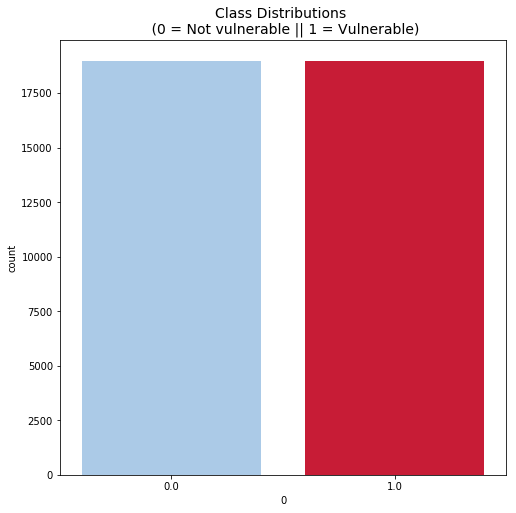

In [150]:
import seaborn as sns
fig = plt.figure()
colors = ["#A1CAF1", "#E30022"]

sns.countplot(0, data=pd.DataFrame(entire_dataset), palette=colors)
plt.title('Class Distributions \n (0 = Not vulnerable || 1 = Vulnerable)', fontsize=14)
fig.set_size_inches(8, 8)
# fig.savefig('./figures/clean_train_unbalanced2class.png', dpi=300) #, bbox_inches='tight'

### Multiclass LSTM Model

In [151]:
# Init
epochs = 50 #100
emb_dim = 128 #150
batch_size = 256 #512   
# labels[:2]

In [152]:
# Clear model
import keras
keras.backend.clear_session()

In [153]:
# Convert format for training  
ytrainres_cat = to_categorical(y_train_res, num_classes=2)
yvalres_cat = to_categorical(y_val_res, num_classes=2)
ytestres_cat = to_categorical(y_test_res, num_classes=2)

print((X_train_res.shape, ytrainres_cat.shape, X_val_res.shape, yvalres_cat.shape, X_test_res.shape, ytestres_cat.shape))

((24300, 130), (24300, 2), (6074, 130), (6074, 2), (7592, 130), (7592, 2))


In [62]:
n_most_common_words = 1000 #150 
model = Sequential()
# n_most_common_words=Size of the vocabulary, emb_dim=Dimension of the dense embedding, input_length=Length of input sequences, when it is constant
model.add(Embedding(n_most_common_words, emb_dim, input_length=X_train_res.shape[1]))
model.add(SpatialDropout1D(0.55))
model.add(LSTM(16, dropout=0.55, recurrent_dropout=0.55))
model.add(Dense(2, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

import time
start_time = time.time()
# Downsampled and balanced dataset
# history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.0,callbacks=[EarlyStopping(monitor='loss',patience=7, min_delta=0.0001)])


history = model.fit(X_train_res, ytrainres_cat, epochs=epochs, batch_size=batch_size, validation_split=0.0, validation_data=(X_val_res, yvalres_cat),callbacks=[EarlyStopping(monitor='loss',patience=7, min_delta=0.0001)])


# history = model.fit(add_greedy_X, add_greedy_y, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

# # Entire and unbalanced dataset
# history = model.fit(under_sample_X, under_sample_y, epochs=epochs, batch_size=batch_size,validation_split=0,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

end_time = time.time()
print('Time taken for training: ', end_time-start_time)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 130, 128)          128000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 130, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                9280      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 137,314
Trainable params: 137,314
Non-trainable params: 0
_________________________________________________________________
None
Train on 19800 samples, validate on 4950 samples
Epoch 1/50
19800/19800 [==============================] - 19s 941us/step - loss: 0.4504 - acc: 0.8975 - val_loss: 0.5998 - val_acc: 0.7426
Epoch 2/50
19800/19800 [==============================] - 17s 866us/step - 

### Test and evaluate model accuracy

In [63]:
accr = model.evaluate(X_test_res, ytestres_cat)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))

6188/6188 [==============================] - 14s 2ms/step
Test set
  Loss: 1.7165
  Accuracy: 0.6335


In [ ]:
y_pred = model.predict_classes(X_test_res, batch_size=32, verbose=1)
ytest_true = y_test_res

In [ ]:
# ytest_true = y_test_res
# y_pred.shape

In [ ]:
from sklearn.metrics import average_precision_score

# Compute the average precision score
average_precision = average_precision_score(ytest_true, y_pred)
print('Average Precision Score: {:0.4f}\n'.format(average_precision))

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(ytest_true, y_pred)
print(recall[1])
print('Recall Score: {:0.4f}\n'.format(recall[1]))

# # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
# step_kwargs = ({'step': 'post'}
#                if 'step' in signature(plt.fill_between).parameters
#                else {})
# plt.step(recall, precision, color='b', alpha=0.2,
#          where='post')
# plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
#           average_precision))

In [ ]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

print('Accuracy:', accuracy_score(ytest_true, y_pred))
print('Recall:', recall_score(ytest_true, y_pred))
print('Precision:', precision_score(ytest_true, y_pred))
print('F1 score:', f1_score(ytest_true, y_pred))
print('\n clasification report:\n', classification_report(ytest_true, y_pred))
print('\n confusion matrix:\n',confusion_matrix(ytest_true, y_pred))

# Plot Performance

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# fig.savefig('clean_train_acc.png',dpi=300)

In [ ]:
fig = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
# fig.savefig('clean_train_loss.png',dpi=300)

In [ ]:
# model.predict(X_test, verbose=1)

### Saving and loading history

In [ ]:
# import json
# # Get the dictionary containing each metric and the loss for each epoch
# history_dict = history.history
# # Save it under the form of a json file
# json.dump(history_dict, open(your_history_path, 'w'))

import pickle
with open('./saved_model/less_imbal/6k_40k', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [ ]:
import pickle
infile = open('./saved_model/cleantrain_final/64_1_best','rb')
history0 = pickle.load(infile)
infile.close()

# Saving and Loading Model

In [ ]:
# Save model to models folder 
model.save('./saved_model/less_imbal/'+ '6k_40k' + '.h5')

In [ ]:
# loading previously saved model
from keras.models import load_model
model = load_model('./saved_model/less_imbal2/'+'9x_450k.h5')

### Saving variables and df pickle

In [ ]:
norm_train = pd.read_pickle('./saved_model/less_imbal2/'+ 'norm_train9x_450k' + '.pkl')
norm_test = pd.read_pickle('./saved_model/less_imbal2/'+ 'norm_test9x_450k' + '.pkl')
print(pd.value_counts(norm_train['CATEGORY']))
print(pd.value_counts(norm_test['CATEGORY']))

In [ ]:
# norm_test = norm_test[:3000]
num_tr = 10000
norm_train = norm_train.sample(num_tr, random_state=9, replace=False)
norm_test = norm_test.sample(num_tr, random_state=9, replace=False)

# trialset = pd.concat([ss,pp,gg,ssp,norm_test], ignore_index=True)
# trialset = pd.concat([ss,pp,gg,ssp], ignore_index=True)
trtrainset = pd.concat([norm_train], ignore_index=True)
trtrainset = trtrainset.sample(frac=1, random_state=39, replace=False)
trtestset = pd.concat([norm_test], ignore_index=True)
trtestset = trtestset.sample(frac=1, random_state=39, replace=False)

# label(trialset)
# pd.value_counts(trialset['LABEL'])
# trialpred = model.predict(preprocess(trialset), verbose=1)
# plt.hist(trialpred[:,0], range=(0,1))

X_trtrain, y_trtrain = dftoXY(trtrainset) #.iloc[:3000]
trtrain_accr = model.evaluate(X_trtrain,y_trtrain)
print('Tr train set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(trtrain_accr[0],trtrain_accr[1]))

X_trtest, y_trtest = dftoXY(trtestset) #.iloc[:3000]
trtest_accr = model.evaluate(X_trtest,y_trtest)
print('Tr test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(trtest_accr[0],trtest_accr[1]))

In [ ]:
positives = pd.concat([s,p,g,sp], ignore_index=True)
positives = positives.sample(frac=1, random_state=39, replace=False)

X_pos, y_pos = dftoXY(positives) 
pos_accr = model.evaluate(X_pos,y_pos)
print('Tr train set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(pos_accr[0],pos_accr[1]))

# Testing

In [ ]:
label(norm_test)
pd.value_counts(norm_test['LABEL'])

In [ ]:
X_neg, y_neg = dftoXY(norm_test) #.iloc[:3000]
neg_accr = model.evaluate(X_neg,y_neg)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(neg_accr[0],neg_accr[1]))

In [ ]:
ntest = norm_test
negtest = preprocess(ntest.iloc[1000:2000])
negt = model.predict(negtest, verbose=1)
plt.hist(negt[:,0], range=(0,1))

# All test FPs

### Loading the dataset

In [ ]:
X_leakFP, y_leakFP = dftoXY(test_leakFPs)
leakFP_accr = model.evaluate(X_leakFP,y_leakFP)
print('Leak test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(leakFP_accr[0],leakFP_accr[1]))

X_suicidalFP, y_suicidalFP = dftoXY(test_suicidalFPs)
suicidalFP_accr = model.evaluate(X_suicidalFP,y_suicidalFP)
print('Suicidal test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(suicidalFP_accr[0],suicidalFP_accr[1]))

X_greedyFP, y_greedyFP = dftoXY(test_lockFPs)
greedyFP_accr = model.evaluate(X_greedyFP,y_greedyFP)
print('Greedy test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(greedyFP_accr[0],greedyFP_accr[1]))

In [ ]:
# FP = 'clean_test_greedyFP_noDups.csv'
# FP = 'clean_test_leakFP_noDups.csv'
FP = 'clean_test_suicidalFP_noDups.csv'

all_test = pd.read_csv('./input_data/final/no_duplicates/'+ FP, usecols=['ADDRESS', 'OPCODE', 'CATEGORY'])

all_X = preprocess(all_test)
pred_all = model.predict(all_X, verbose=1)

fig = plt.figure()
plt.hist(pred_all[:,1])
plt.xlabel('Prediction (0.0 = Not vulnerable, 1.0 = Vulnerable)')
plt.ylabel('Number of samples')
plt.title('Distribution of LSTM Prediction on All FPs')
# plt.legend()
# fig.savefig('./figures/AllFP_distr.png',dpi=300)

predall_pos = np.count_nonzero(pred_all[:,1] < 0.5)
print(predall_pos)
predall_accr = predall_pos / len(pred_all)
print('Test set\n Accuracy: {:0.4f}'.format(predall_accr))

# Plot Performance

In [ ]:
import pickle
infile = open('./saved_model/less_imbal2/' + '15x_750k','rb')
history0 = pickle.load(infile)
infile.close()

In [ ]:
# acc = history.history['acc']
# val_acc = history.history['val_acc']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

acc = history0['acc']
val_acc = history0['val_acc']
loss = history0['loss']
val_loss = history0['val_loss']


epochs = range(1, len(acc) + 1)

fig = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

fig.savefig('./figures/clean_train_acc.png',dpi=300)

In [ ]:
fig = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
fig.savefig('./figures/clean_train_loss.png',dpi=300)

### Collecting and saving flagged negatives for validation

In [ ]:
pred_neg = model.predict(X_trtest, verbose=1)

In [ ]:
predneg = np.count_nonzero(pred_neg[:,1] > 0.5)
predneg_accr = predneg / len(pred_neg)
print('Percentage of Negatives Flagged: {:0.4f}'.format(predneg_accr))

LSTM_pos = np.nonzero(pred_neg[:,1] > 0.5)
np.array(np.nonzero(pred_neg[:,1] > 0.5)).shape

lstm_Negflagged = norm_test.iloc[LSTM_pos]
# lstm_Negflagged.to_csv ('./output_data/lstm_flaggedNeg_final.csv', index = None, header=True)

In [ ]:
fig = plt.figure()
plt.hist(pred_neg[:,1])
plt.xlabel('Prediction (less than 0.5 (Not vulnerable), greater than 0.5 (Vulnerable))')
plt.ylabel('Number of samples')
plt.title('Distribution of LSTM Prediction on Unflagged Contracts')

fig.savefig('./figures/lstm_flaggedNeg_final.png',dpi=300)

# Saving and Loading Trained Model

In [ ]:
model_name = "v3_550KLSTM64epoch100train0.64drop0.55"

# "v3_550KLSTM64epoch100train0.64drop0.5"

In [ ]:
# loading previously saved model
from keras.models import load_model
# model = load_model('./saved_model/less_imbal2/'+'9x_450k.h5')
model = load_model('./saved_model/postreviewV3/'+ 'train' + model_name + '.h5')